# Applied Machine Learning - Project 1
### Boaz Shvartzman, Ofir Ziv

In [1]:
%matplotlib notebook

In [2]:
from __future__ import division, print_function

import datetime
import json
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [3]:
np.random.seed(1234)

## Part 1

    1.

In [4]:
class RatingsData(object):
    def __init__(self, raw_data_path):
        with open(raw_data_path, 'r') as f:
            content = f.read()

        self._ratings_data = {}

        for line in content.split('\n'):
            if not line:
                continue
                
            values = line.split('::')
            user_ratings = self._ratings_data.get(values[0], {})
            user_ratings[values[1]] = float(values[2])
            self._ratings_data[values[0]] = user_ratings

    def as_matrix(self, movies):

        sorted_users = sorted(self._ratings_data.keys())

        matrix = []

        for user_id in sorted_users:
            row = []
            for movie in movies:
                row.append(self._ratings_data[user_id].get(movie, np.NaN))
            matrix.append(row)

        return np.array(matrix)

    2.

In [5]:
class MoviesData(object):

    def __init__(self, raw_data_path):
        with open(raw_data_path, 'r') as f:
            content = f.read()

        self._movies_data = {}

        for line in content.split('\n'):
            if not line:
                continue
                
            values = line.split('::')
            self._movies_data[values[0]] = {
                'name': values[1],
                'genres': values[2].split('|')
            }

    def get_available_movies(self):
        return sorted(self._movies_data.keys())
    
    def get_available_movie_names(self):
        return np.array([self._movies_data[i]['name'] for i in sorted(self._movies_data.keys())])

    3.

In [6]:
def split_train_test(ratings_matrix, ratio=0.8):

    known_ratings = np.argwhere(~np.isnan(ratings_matrix))
    random_order = np.random.permutation(len(known_ratings))
    
    has_test, has_train = {}, {}
    train, test = [], []
    
    for user, movie in known_ratings[random_order]:
        
        if has_test.setdefault(user, movie) == movie:
            test.append((user, movie))
            
        elif has_train.setdefault(user, movie) == movie:
            train.append((user, movie))
        
        elif float(len(test)) / len(train) < (1 - ratio) / ratio:
            test.append((user, movie))
        
        else:
            train.append((user, movie))
            
    train_set = np.full(ratings_matrix.shape, np.NaN)
    test_set = np.full(ratings_matrix.shape, np.NaN)
    
    train_set[zip(*train)] = ratings_matrix[zip(*train)]
    test_set[zip(*test)] = ratings_matrix[zip(*test)]
    
    return train_set, test_set

## Part 2

1. Required **hyper**parameters:  
  * $d$ - Dimensionality factor
  * $\lambda_u$ - Users rows regularization factor
  * $\lambda_v$ - Movies rows regularization factor
  * $\lambda_{b_u}$ - Users rows bias regularization factor
  * $\lambda_{b_v}$ - Movies rows bias regularization factor

In [7]:
class Hyperparameters(object):

    def __init__(self, dim, reg_users=1e-3, reg_movies=1e-3, reg_bias_users=1e-3, reg_bias_movies=1e-3):
        self.d = dim
        self.lambda_u = reg_users
        self.lambda_v = reg_movies
        self.lambda_bu = reg_bias_users
        self.lambda_bv = reg_bias_movies
        
    def __str__(self):
        return '\n'.join(['Dimensionality factor: {}'.format(self.d),
                          'Users regularization factor: {}'.format(self.lambda_u),
                          'Movies regularization factor: {}'.format(self.lambda_v),
                          'Users bias regularization factor: {}'.format(self.lambda_bu),
                          'Movies bias regularization factor: {}'.format(self.lambda_bv)])

    2.

In [8]:
class MFModel(object):

    def __init__(self, hyperparams, trainset):

        self.hyper = hyperparams
        
        var_factor = 0.1
        
        self.U = np.random.randn(hyperparams.d, trainset.shape[0]) * var_factor
        self.V = np.random.randn(hyperparams.d, trainset.shape[1]) * var_factor
        self.Ub = np.random.randn(trainset.shape[0], 1) * var_factor
        self.Vb = np.random.randn(trainset.shape[1], 1) * var_factor
        self.mu = trainset[~np.isnan(train_set)].mean()

## Part 3

    1.
$$ \frac{\partial E}{\partial U_m} = 
\sum_{n \in I_m} \left ( \left (ֿ\mu + U_m^TV_n + b_n + b_m \right ) - r_{m,n} \right ) V_n + \lambda_UU_m$$

$$ \frac{\partial E}{\partial V_n} = 
\sum_{m \in I_n} \left ( \left (\mu + U_m^TV_n + b_n + b_m \right ) - r_{m,n} \right ) U_m + \lambda_VV_n$$

$$ \frac{\partial E}{\partial b_m} = 
\sum_{n \in I_m} \left ( \left (\mu + U_m^TV_n + b_n + b_m \right ) - r_{m,n} \right ) + \lambda_{b_u}b_m$$

$$ \frac{\partial E}{\partial b_n} = 
\sum_{m \in I_m} \left ( \left (\mu + U_m^TV_n + b_n + b_m \right ) - r_{m,n} \right ) + \lambda_{b_v}b_n$$

    2. 
        (a)

In [9]:
def derive_by_um(R, mu, U, V, Ub, Vb, lambda_u, m):
    ns = np.argwhere(~np.isnan(R[m])).reshape(-1)
    Vns, Um = V[:, ns], U[:, m].reshape(-1, 1)
    error = (mu + np.dot(Vns.T, Um) + Vb[ns] + Ub[m] - R[m, ns].reshape(-1, 1)) * Vns.T

    return error.sum(axis=0) + lambda_u * U[:, m]

def derive_by_vn(R, mu, U, V, Ub, Vb, lambda_v, n):
    ms = np.argwhere(~np.isnan(R[:, n])).reshape(-1)
    Vn, Ums = V[:, n].reshape(-1, 1), U[:, ms]
    error = (mu + np.dot(Ums.T, Vn) + Vb[n] + Ub[ms].reshape(-1, 1) - R[ms, n].reshape(-1, 1)) * Ums.T

    return error.sum(axis=0) + lambda_v * V[:, n]

def derive_by_bm(R, mu, U, V, Ub, Vb, lambda_bu, m):
    ns = np.argwhere(~np.isnan(R[m])).reshape(-1)
    Vns, Um = V[:, ns], U[:, m].reshape(-1, 1)
    error = (mu + np.dot(Vns.T, Um) + Vb[ns] + Ub[m] - R[m, ns].reshape(-1, 1))

    return error.sum() + lambda_bu * Ub[m]

def derive_by_bn(R, mu, U, V, Ub, Vb, lambda_bv, n):
    ms = np.argwhere(~np.isnan(R[:, n])).reshape(-1)
    Vn, Ums = V[:, n].reshape(-1, 1), U[:, ms]
    error = (mu + np.dot(Ums.T, Vn) + Vb[n] + Ub[ms].reshape(-1, 1) - R[ms, n].reshape(-1, 1))

    return error.sum() + lambda_bv * Vb[n]

        (b)

In [10]:
class SGDParameters(object):
    
    def __init__(self, step_size=1e-3, epocs=50, stop_threshold=10):
        self.alpha = step_size
        self.epocs = epocs
        self.stop_threshold = stop_threshold
        
    def __str__(self):
        return 'SGD epocs: {}\nSGD Step size: {}\nSGD stop threshold: {}'.format(self.epocs, self.alpha, self.stop_threshold)

        (c)

In [11]:
def loss(groundtruth, mu, U, V, Ub, Vb, hyper):
    mask = np.where(~np.isnan(groundtruth))
    predictions = mu + np.dot(U.T, V) + Ub.reshape(-1, 1) + Vb.reshape(-1, 1).T
    reg = (hyper.lambda_u / 2.0) * (U * U).sum() + (hyper.lambda_v / 2.0) * (V * V).sum()
    reg += (hyper.lambda_bu / 2.0) * np.power(Ub, 2).sum() + (hyper.lambda_bv / 2.0) * np.power(Vb, 2).sum()
    return 0.5 * np.power(groundtruth[mask] - predictions[mask], 2).sum() + reg

def LearnModelFromDataUsingSGD(trainset, model_params, algorithm_params):
    
    mu, U, V, Ub, Vb = model_params.mu, model_params.U, model_params.V, model_params.Ub, model_params.Vb
    lambda_u, lambda_v = model_params.hyper.lambda_u, model_params.hyper.lambda_v
    lambda_bu, lambda_bv = model_params.hyper.lambda_bu, model_params.hyper.lambda_bv
    
    rated = np.argwhere(~np.isnan(trainset))
    epocs = np.random.permutation(len(rated))[:algorithm_params.epocs]
    
    prev_loss = np.inf

    for m, n in rated[epocs]:
        
        new_loss = loss(trainset, mu, U, V, Ub, Vb, model_params.hyper)

        if prev_loss - new_loss < algorithm_params.stop_threshold:
            break

        prev_loss = new_loss
        
        U[:, m] -= algorithm_params.alpha * derive_by_um(trainset, mu, U, V, Ub, Vb, lambda_u, m)
        V[:, n] -= algorithm_params.alpha * derive_by_vn(trainset, mu, U, V, Ub, Vb, lambda_v, n)
        Ub[m] -= algorithm_params.alpha * derive_by_bm(trainset, mu, U, V, Ub, Vb, lambda_bu, m)
        Vb[n] -= algorithm_params.alpha * derive_by_bn(trainset, mu, U, V, Ub, Vb, lambda_bv, n)

    return mu, U, V, Ub, Vb

    3.
        (a)
$$ U_m = \left( \sum_{n \in I_m} \left(V_nV_n^T \right) + \lambda_UI \right)^{-1} \cdot \sum_{n \in I_m} \left(r_{m,n} - 
\mu - b_n - b_m \right)V_n$$
$$ V_n = \left( \sum_{n \in I_m} \left(U_mU_m^T \right) + \lambda_VI \right)^{-1} \cdot \sum_{n \in I_m} \left(r_{m,n} - 
\mu - b_n - b_m \right)U_m$$
$$  b_m = \frac{1}{\left| I_m \right| + \lambda_{b_u}} \cdot \left(\sum_{n \in I_m} r_{m,n} - 
\mu - U_m^TV_n - b_n  \right)$$
$$  b_n = \frac{1}{\left| I_n \right| + \lambda_{b_v}} \cdot \left(\sum_{n \in I_m} r_{m,n} - 
\mu - U_m^TV_n - b_m  \right)$$

In [12]:
def get_um(R, mu, U, V, Ub, Vb, lambda_u, m):
    ns = np.argwhere(~np.isnan(R[m])).reshape(-1)
    Vns = V[:, ns]
    error = np.sum((R[m, ns].reshape(-1, 1) - mu - Vb[ns] - Ub[m]) * Vns.T, axis=0)
    inv = np.linalg.inv(np.dot(Vns, Vns.T) + np.eye(V.shape[0]) * lambda_u)
    return np.dot(inv, error)

def get_vn(R, mu, U, V, Ub, Vb, lambda_v, n):
    ms = np.argwhere(~np.isnan(R[:, n])).reshape(-1)
    Ums = U[:, ms]
    error = np.sum((R[ms, n].reshape(-1, 1) - mu - Vb[n] - Ub[ms]) * Ums.T, axis=0)
    inv = np.linalg.inv(np.dot(Ums, Ums.T) + np.eye(U.shape[0]) * lambda_v)
    return np.dot(inv, error)

def get_bm(R, mu, U, V, Ub, Vb, lambda_bu, m):
    ns = np.argwhere(~np.isnan(R[m])).reshape(-1)
    n = 1.0 / (len(ns) + lambda_bu)
    Vns, Um = V[:, ns], U[:, m].reshape(-1, 1)
    error = (R[m, ns].reshape(-1, 1) - mu - np.dot(Vns.T, Um) - Vb[ns].reshape(-1, 1))
    return n * np.sum(error)

def get_bn(R, mu, U, V, Ub, Vb, lambda_bv, n):
    ms = np.argwhere(~np.isnan(R[:, n])).reshape(-1)
    m = 1.0 / (len(ms) + lambda_bv)
    Vn, Ums = V[:, n].reshape(-1, 1), U[:, ms]
    error = (R[ms, n].reshape(-1, 1) - mu - np.dot(Ums.T, Vn) - Ub[ms].reshape(-1, 1))
    return m * np.sum(error)

    (b)

In [13]:
class ALSParameters(object):
    
    def __init__(self, epocs=50, stop_threshold=10):
        self.epocs = epocs
        self.stop_threshold = stop_threshold
        
    def __str__(self):
        return 'ALS epocs: {}\nALS stop threshold: {}'.format(self.epocs, self.stop_threshold)

    (c)

In [14]:
class MFWorker(object):
    
    def __init__(self, func, params):
        self._func = func
        self._params = params
        
    def __call__(self, x):
        params = list(self._params) + [x]
        return self._func(*params)

class ParallelRunner(object):
    
    def __init__(self):
        self.pool = multiprocessing.Pool()
    
    def map(self, worker, data):
        return self.pool.map(worker, data)
        
parallel_runner = ParallelRunner()    

def LearnModelFromDataUsingALS(trainset, model_params, algorithm_params):

    mu, U, V, Ub, Vb = model_params.mu, model_params.U, model_params.V, model_params.Ub, model_params.Vb
    lambda_u, lambda_v = model_params.hyper.lambda_u, model_params.hyper.lambda_v
    lambda_bu, lambda_bv = model_params.hyper.lambda_bu, model_params.hyper.lambda_bv
    
    prev_loss = np.inf
    
    for epoc in range(algorithm_params.epocs):
        
        new_loss = loss(trainset, mu, U, V, Ub, Vb, model_params.hyper)

        if prev_loss - new_loss < algorithm_params.stop_threshold:
            break

        prev_loss = new_loss

        um_worker = MFWorker(get_um, (trainset, mu, U, V, Ub, Vb, lambda_u))
        U = np.array(parallel_runner.map(um_worker, range(U.shape[1]))).T
        
        bm_worker = MFWorker(get_bm, (trainset, mu, U, V, Ub, Vb, lambda_bu))
        Ub = np.array(parallel_runner.map(bm_worker, range(U.shape[1]))).reshape(-1, 1)
        
        vn_worker = MFWorker(get_vn, (trainset, mu, U, V, Ub, Vb, lambda_v))
        V = np.array(parallel_runner.map(vn_worker, range(V.shape[1]))).T
        
        bn_worker = MFWorker(get_bn, (trainset, mu, U, V, Ub, Vb, lambda_bv))
        Vb = np.array(parallel_runner.map(bn_worker, range(V.shape[1]))).reshape(-1, 1)
           
    return mu, U, V, Ub, Vb

## Part 4

In [15]:
def SSE(groundtruth, predictions):
    mask = ~np.isnan(groundtruth)
    return np.power(predictions[mask] - groundtruth[mask], 2).sum()

def SGD_optimzer(trainset, model_params, algorithm_params):
    
    mu, U, V, Ub, Vb = model_params.mu, model_params.U, model_params.V, model_params.Ub, model_params.Vb
    lambda_u, lambda_v = model_params.hyper.lambda_u, model_params.hyper.lambda_v
    lambda_bu, lambda_bv = model_params.hyper.lambda_bu, model_params.hyper.lambda_bv

    prev_loss = np.inf
    rated = np.argwhere(~np.isnan(trainset))
    epocs = np.random.choice(len(rated), algorithm_params.epocs)

    for epoc, (m, n) in enumerate(rated[epocs]):
        
        if epoc % 20000 == 0:
            
            yield epoc, (mu, U, V, Ub, Vb)
            
            new_loss = loss(trainset, mu, U, V, Ub, Vb, model_params.hyper)

            if prev_loss - new_loss < algorithm_params.stop_threshold:
                raise StopIteration
                
            prev_loss = new_loss

        U[:, m] -= algorithm_params.alpha * derive_by_um(trainset, mu, U, V, Ub, Vb, lambda_u, m)
        V[:, n] -= algorithm_params.alpha * derive_by_vn(trainset, mu, U, V, Ub, Vb, lambda_v, n)
        Ub[m] -= algorithm_params.alpha * derive_by_bm(trainset, mu, U, V, Ub, Vb, lambda_bu, m)
        Vb[n] -= algorithm_params.alpha * derive_by_bn(trainset, mu, U, V, Ub, Vb, lambda_bv, n)
        
    raise StopIteration

        
def ALS_optimzer(trainset, model_params, algorithm_params):

    mu, U, V, Ub, Vb = model_params.mu, model_params.U, model_params.V, model_params.Ub, model_params.Vb
    lambda_u, lambda_v = model_params.hyper.lambda_u, model_params.hyper.lambda_v
    lambda_bu, lambda_bv = model_params.hyper.lambda_bu, model_params.hyper.lambda_bv

    prev_loss = np.inf
    
    for epoc in range(algorithm_params.epocs):
        
        yield epoc, (mu, U, V, Ub, Vb)
        
        new_loss = loss(trainset, mu, U, V, Ub, Vb, model_params.hyper)
            
        if prev_loss - new_loss < algorithm_params.stop_threshold:
            raise StopIteration

        prev_loss = new_loss
        
        um_worker = MFWorker(get_um, (trainset, mu, U, V, Ub, Vb, lambda_u))
        U = np.array(parallel_runner.map(um_worker, range(U.shape[1]))).T
        
        bm_worker = MFWorker(get_bm, (trainset, mu, U, V, Ub, Vb, lambda_bu))
        Ub = np.array(parallel_runner.map(bm_worker, range(U.shape[1]))).reshape(-1, 1)
        
        vn_worker = MFWorker(get_vn, (trainset, mu, U, V, Ub, Vb, lambda_v))
        V = np.array(parallel_runner.map(vn_worker, range(V.shape[1]))).T
        
        bn_worker = MFWorker(get_bn, (trainset, mu, U, V, Ub, Vb, lambda_bv))
        Vb = np.array(parallel_runner.map(bn_worker, range(V.shape[1]))).reshape(-1, 1)
        
    raise StopIteration
        
        
def learn_model_from_data(optimizer_name, trainset, model_params, algorithm_params, testset=None, verbose=False):
    
    if optimizer_name == 'ALS':
        optimzer = ALS_optimzer
        
    elif optimizer_name == 'SGD':
        optimzer = SGD_optimzer
        
    else:
        raise Exception('Unknown optimzer')
        
    open(optimizer_name + '_train_output.txt', 'w').close()
    
    if testset is not None:
        open(optimizer_name + '_test_output.txt', 'w').close()
        
    epoc_time = '-'
    prev_epoc = 0
    time_before = datetime.datetime.now()
    
    for epoc, params in optimzer(trainset, model_params, algorithm_params):
        
        epoc_time = datetime.datetime.now() - time_before
        ratings, rankings = get_predictions(*params)
        train_sse = SSE(trainset, ratings)
        
        with open(optimizer_name + '_train_output.txt', 'a') as f:
            f.write(str(train_sse) + '\n')
        
        if testset is not None:
            test_sse = SSE(testset, ratings)
            
            with open(optimizer_name + '_test_output.txt', 'a') as f:
                f.write(str(test_sse) + '\n')
                
        if verbose:
            status = 'Epoch: {:<15}Train SSE: {:<20.5f}'.format(epoc, train_sse)
            
            if testset is not None:
                status += 'Test SSE: {:<20.5f}'.format(test_sse)
                
            status += 'Last {} epoc(s): {}'.format(epoc - prev_epoc, str(epoc_time))
            print(status)
                
        time_before = datetime.datetime.now()
        prev_epoc = epoc
        
    return params


def LearnModelFromDataUsingSGD(*args, **kwargs):
    return learn_model_from_data('SGD', *args, **kwargs)
        
def LearnModelFromDataUsingALS(*args, **kwargs):
    return learn_model_from_data('ALS', *args, **kwargs)

## Part 5

    1.

In [16]:
def get_predictions(mu, U, V, Ub, Vb):
    ratings = mu + np.dot(U.T, V) + Ub.reshape(-1, 1) + Vb.reshape(-1, 1).T
    return ratings, np.argsort(-ratings)

    2.

In [17]:
def RMSE(groundtruth, predictions):
    mask = ~np.isnan(groundtruth)
    return np.sqrt(np.power(predictions[mask] - groundtruth[mask], 2).sum() / mask.sum())

def MPR(groundtruth, rankings):

    users_ranks = []
    
    for i, user in enumerate(groundtruth):
        groundtruth_movies = np.argwhere(~np.isnan(user))
        indices = np.argwhere(np.isin(rankings[i], groundtruth_movies)) # Predicted rankings of user rated movies
        avg_rank = indices.mean()
        users_ranks.append(avg_rank / rankings.shape[1])
        
    return np.array(users_ranks).mean()
                                        
def precision(groundtruth, rankings, k):
                 
    groundtruth_movies = ~np.isnan(groundtruth)
    
    rows = np.repeat(range(groundtruth.shape[0]), k) # k rows for each user
    columns = rankings[:, :k].reshape(-1) # Top k ratings of each user
    
    predicted_movies = groundtruth == np.NaN
    predicted_movies[rows, columns] = True # Only top k ratings of each user
    
    return (groundtruth_movies & predicted_movies).sum(axis=1) / float(k)
                                           
def recall(groundtruth, rankings, k):
                       
    groundtruth_movies = ~np.isnan(groundtruth)
    
    rows = np.repeat(range(groundtruth.shape[0]), k)
    columns = rankings[:, :k].reshape(-1)
    
    predicted_movies = groundtruth == np.NaN
    predicted_movies[rows, columns] = True
    
    return (groundtruth_movies & predicted_movies).sum(axis=1) / groundtruth_movies.sum(axis=1).astype(float)

def MAP(groundtruth, rankings):

    rating_counts = (~np.isnan(groundtruth)).sum(axis=1)
    indicators = np.full((groundtruth.shape[0], rating_counts.max()), np.NaN)
    
    for i in range(rating_counts.max()):
        indicators[:, i] = ~np.isnan(groundtruth[range(groundtruth.shape[0]), rankings[:, i]])
        
    hits = indicators.cumsum(axis=1)
    recalls = hits / rating_counts.reshape(-1, 1)
    prev_recalls = np.hstack((np.zeros((groundtruth.shape[0], 1)), recalls[:, :-1]))
    precisions = hits / (np.arange(rating_counts.max()) + 1.0)
    
    avg_p = (precisions * (recalls - prev_recalls)).sum(axis=1)
    return avg_p.mean()

    3.

In [18]:
def print_user_recommendations(user_index, dataset, params, top_h=10):

    available_movies = movies.get_available_movie_names()
    user_ratings = dataset[user_index]
    rated_movies_names = available_movies[np.argwhere(~np.isnan(user_ratings))].reshape(-1)
    
    print('\n Rating history')
    print(' ' + '_' * 70)
    rated_pairs = zip(rated_movies_names, user_ratings[~np.isnan(user_ratings)])
    for name, rating in sorted(rated_pairs, key=lambda x: x[1], reverse=True):
        print('| {:<62.62} | {:.1f} |'.format(name, int(rating)))
    print(' ' + '_' * 70)
    
    predicted_ratings, predicted_rank = get_predictions(*params)
    top_h_recommendations = predicted_rank[user_index, :top_h]
    recommendation_names = available_movies[top_h_recommendations]
    recommendation_ratings = predicted_ratings[user_index, top_h_recommendations]
    
    print('\n Top-{} Recommendations'.format(top_h))
    print(' ' + '_' * 70)
    recommended_pairs = zip(recommendation_names, recommendation_ratings)
    for name, rating in sorted(recommended_pairs, key=lambda x: x[1], reverse=True):
        print('| {:<62.62} | {:.1f} |'.format(name, rating))
    print(' ' + '_' * 70)

## Part 6

    1.

In [19]:
movies = MoviesData('movies.dat')
ratings = RatingsData('ratings.dat')

full_dataset = ratings.as_matrix(movies.get_available_movies())
train_set, test_set = split_train_test(full_dataset)

    2.

In [20]:
def load_mf_config(path):

    with open(path, 'r') as config_file:
        mf_config = json.load(config_file)

    hyperparameters = Hyperparameters(**mf_config['hyperparameters'])
    model_params = MFModel(hyperparameters, train_set)

    if mf_config['algorithm'] == 'SGD':
        algorithm_params = SGDParameters(**mf_config['algorithm_parameters'])
        trainer = LearnModelFromDataUsingSGD

    elif mf_config['algorithm'] == 'ALS':
        algorithm_params = ALSParameters(**mf_config['algorithm_parameters'])
        trainer = LearnModelFromDataUsingALS

    else:
        raise 'Unknown algorithm specified'
        
    return trainer, model_params, algorithm_params
        
trainer, model_params, algorithm_params = load_mf_config('config.json')

    3.

In [21]:
time_before = datetime.datetime.now()
learned_params = trainer(train_set, model_params, algorithm_params, test_set, verbose=True)
time_after = datetime.datetime.now()

Epoch: 0              Train SSE: 1018975.17982       Test SSE: 254676.96116        Last 0 epoc(s): 0:00:00.201742
Epoch: 20000          Train SSE: 731512.66512        Test SSE: 184901.53329        Last 20000 epoc(s): 0:00:14.254649
Epoch: 40000          Train SSE: 704799.68055        Test SSE: 178814.74198        Last 20000 epoc(s): 0:00:12.899324
Epoch: 60000          Train SSE: 691427.80135        Test SSE: 175827.49368        Last 20000 epoc(s): 0:00:12.754643
Epoch: 80000          Train SSE: 681020.26036        Test SSE: 173623.74883        Last 20000 epoc(s): 0:00:12.827354
Epoch: 100000         Train SSE: 670652.30652        Test SSE: 171506.72426        Last 20000 epoc(s): 0:00:12.784293
Epoch: 120000         Train SSE: 659536.10744        Test SSE: 169245.47413        Last 20000 epoc(s): 0:00:12.562628
Epoch: 140000         Train SSE: 649201.33758        Test SSE: 167133.43806        Last 20000 epoc(s): 0:00:12.562814
Epoch: 160000         Train SSE: 640201.68996        Test SS

    4.

In [22]:
predicted_ratings, predicted_rankings = get_predictions(*learned_params)

metrics = {
    'RMSE': RMSE(test_set, predicted_ratings),
    'MPR': MPR(test_set, predicted_rankings),
    'P@2': precision(test_set, predicted_rankings, 2).mean(),
    'P@10': precision(test_set, predicted_rankings, 10).mean(),
    'R@2': recall(test_set, predicted_rankings, 2).mean(),
    'R@10': recall(test_set, predicted_rankings, 10).mean(),
    'MAP': MAP(test_set, predicted_rankings)
}

    5.

In [23]:
output_file = open('mf_run_sum.txt', 'w')

output_file.write('Hyperparameters\n-------------\n' + str(model_params.hyper) + '\n\n')
output_file.write('Algorithm parameters\n------------------\n' + str(algorithm_params) + '\n\n')
output_file.write('Metrics\n-------\n')

for metric, value in sorted(metrics.items(), key=lambda x: x[0]):
    output_file.write('{:<10.10} {:.2f}\n'.format(metric + ':', value))
    
output_file.write('\nTraining time\n--------------\n{}'.format(time_after - time_before))
output_file.close()

## Deliverable 1

Optimzer: SGD
Dimensionality factor: 4
Users regularization factor: 10
Movies regularization factor: 10
Users bias regularization factor: 10
Movies bias regularization factor: 10

SGD epocs: 800000
SGD Step size: 0.0007
SGD stop threshold: 100


<IPython.core.display.Javascript object>


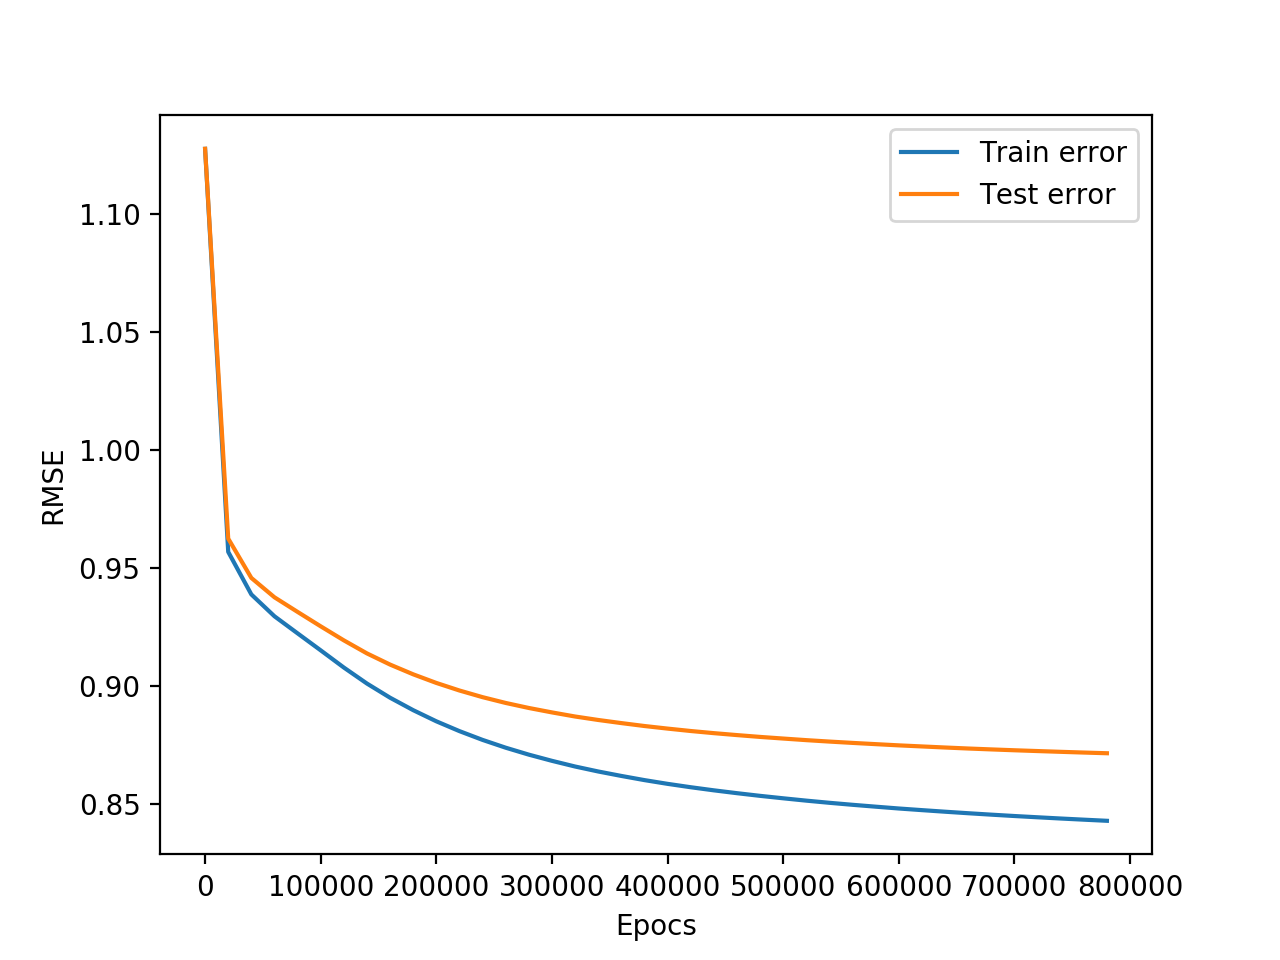

In [24]:
display(HTML('<span style="font-size: 24pt; background-color: #00ff00">Deliverable 1</span>'))

with open('sgd_config.json', 'r') as config_file:
    mf_config = json.load(config_file)
    
hyperparameters = Hyperparameters(**mf_config['hyperparameters'])
algorithm_params = SGDParameters(**mf_config['algorithm_parameters'])
model_params = MFModel(hyperparameters, train_set)

print('Optimzer: \033[1mSGD\033[0m')
print(str(hyperparameters) + '\n')
print(algorithm_params)

epocs, train_errors, test_errors = [], [], []

for epoc, params in SGD_optimzer(train_set, model_params, algorithm_params):
    epocs.append(epoc)
    
    ratings, rankings = get_predictions(*params)
    train_errors.append(RMSE(train_set, ratings))
    test_errors.append(RMSE(test_set, ratings))

plt.figure()
plt.plot(epocs, train_errors, label='Train error')
plt.plot(epocs, test_errors, label='Test error')

plt.xlabel('Epocs')
plt.ylabel('RMSE')
plt.legend()
pass

Optimzer: ALS
Dimensionality factor: 4
Users regularization factor: 5
Movies regularization factor: 5
Users bias regularization factor: 5
Movies bias regularization factor: 5

ALS epocs: 50
ALS stop threshold: 100


<IPython.core.display.Javascript object>


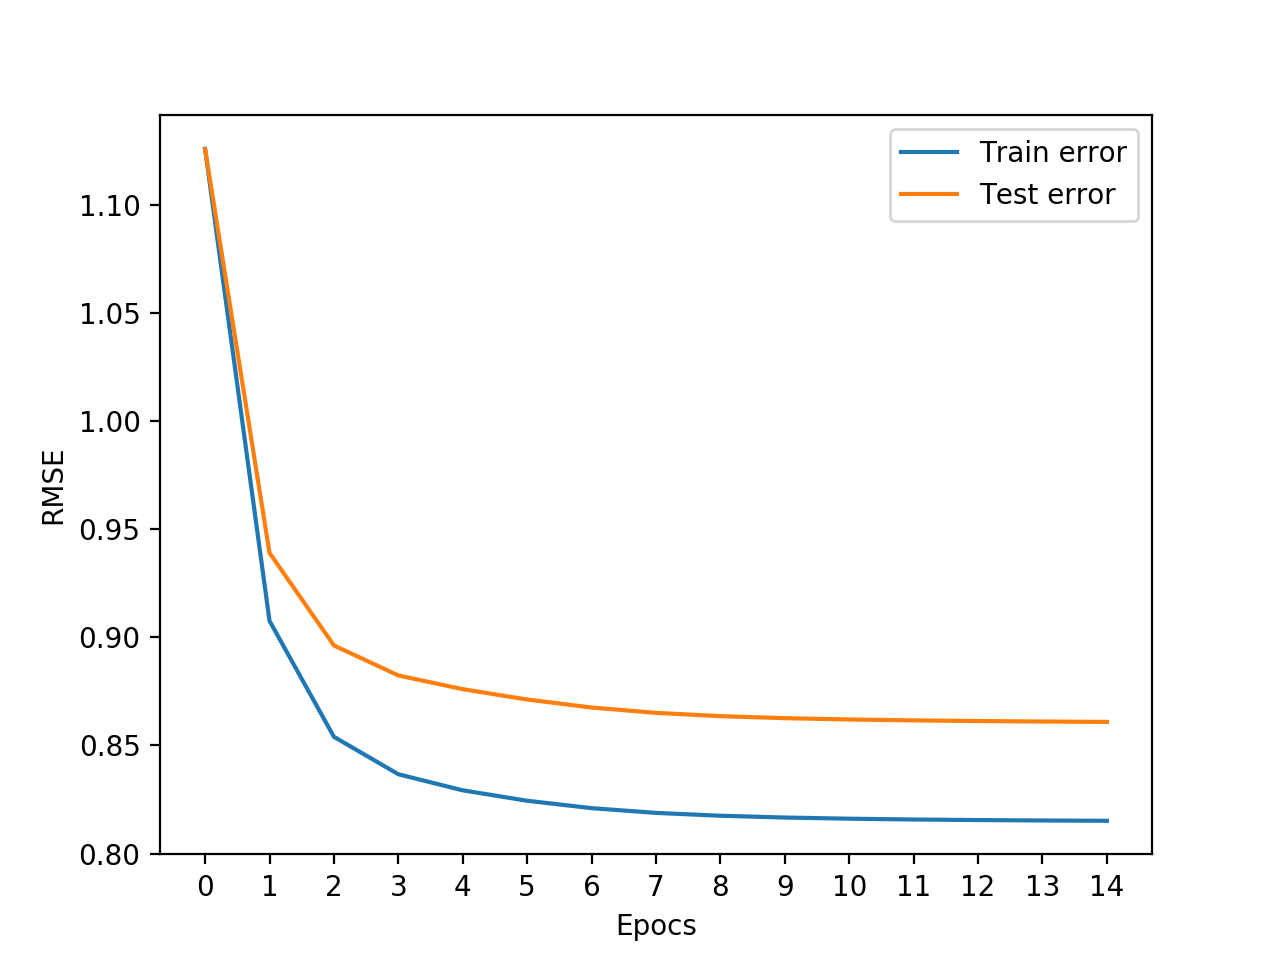

In [25]:
with open('als_config.json', 'r') as config_file:
    mf_config = json.load(config_file)
    
hyperparameters = Hyperparameters(**mf_config['hyperparameters'])
algorithm_params = ALSParameters(**mf_config['algorithm_parameters'])
model_params = MFModel(hyperparameters, train_set)

print('Optimzer: \033[1mALS\033[0m')
print(str(hyperparameters) + '\n')
print(algorithm_params)

epocs, train_errors, test_errors = [], [], []

for epoc, params in ALS_optimzer(train_set, model_params, algorithm_params):
    epocs.append(str(epoc))
    
    ratings, rankings = get_predictions(*params)
    train_errors.append(RMSE(train_set, ratings))
    test_errors.append(RMSE(test_set, ratings))

plt.figure()
plt.plot(epocs, train_errors, label='Train error')
plt.plot(epocs, test_errors, label='Test error')

plt.xlabel('Epocs')
plt.ylabel('RMSE')
plt.legend()
pass

## Deliverable 2

In [26]:
reg_values = [0.1, 1, 10, 100, 1000]

rmse_values, map_values = [], []
algorithm_params = ALSParameters(epocs=50, stop_threshold=100)

for reg in reg_values:
    hyperparameters = Hyperparameters(4, reg_users=reg, reg_movies=reg, reg_bias_users=reg, reg_bias_movies=reg)
    model_params = MFModel(hyperparameters, train_set)
    params = LearnModelFromDataUsingALS(train_set, model_params, algorithm_params, testset=test_set)
    predicted_ratings, predicted_rankings = get_predictions(*params)
    
    rmse_values.append(RMSE(test_set, predicted_ratings))
    map_values.append(MAP(test_set, predicted_rankings))

Optimzer: ALS
Dimensionality factor: 4
ALS epocs: 50
ALS stop threshold: 100


<IPython.core.display.Javascript object>


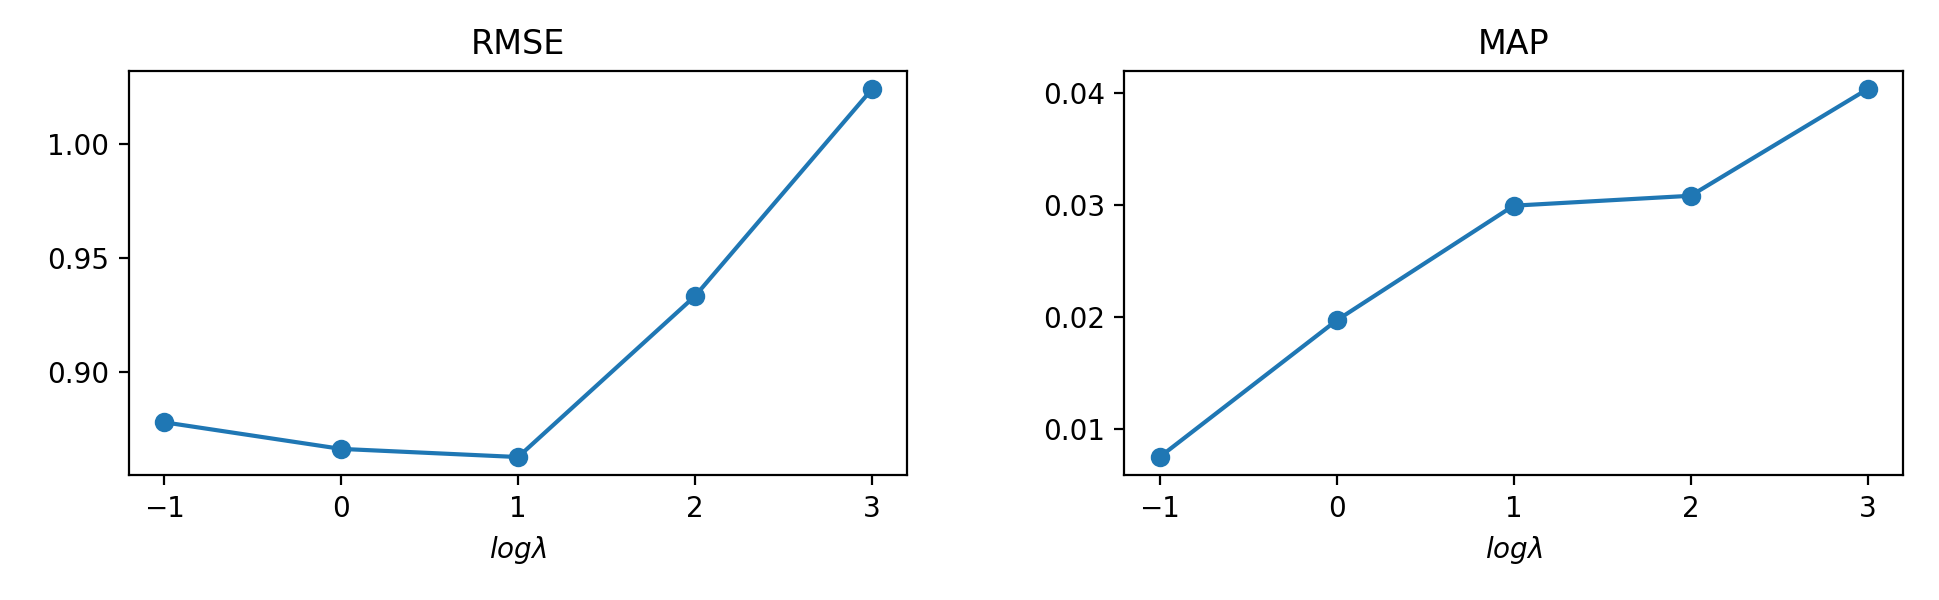

In [27]:
display(HTML('<span style="font-size: 24pt; background-color: #00ff00">Deliverable 2</span>'))
print('Optimzer: \033[1mALS\033[0m')
print('Dimensionality factor: ' + str(hyperparameters.d))
print(algorithm_params)

f, axarr = plt.subplots(1, 2, figsize=(9.7, 3))

reg_values = np.log10([0.1, 1, 10, 100, 1000])

axarr[0].plot(reg_values, rmse_values, marker='o')
axarr[0].set_title('RMSE')
axarr[0].set_xlabel(r'$log\lambda$')
axarr[0].set_xticks(reg_values)

axarr[1].plot(reg_values, map_values, marker='o')
axarr[1].set_title('MAP')
axarr[1].set_xlabel(r'$log\lambda$')
axarr[1].set_xticks(reg_values)

plt.tight_layout(w_pad=4.0)
pass

## Deliverable 3

In [28]:
latent_dimensions = [2, 4, 10, 20, 40, 50, 70, 100, 200]

rmse_values, map_values, train_times = [], [], []
algorithm_params = ALSParameters(epocs=50, stop_threshold=100)

for dim in latent_dimensions:
    hyperparameters = Hyperparameters(dim, reg_users=10.0, reg_movies=10.0, reg_bias_users=10.0, reg_bias_movies=10.0)
    model_params = MFModel(hyperparameters, train_set)
    time_before = datetime.datetime.now()
    params = LearnModelFromDataUsingALS(train_set, model_params, algorithm_params, testset=test_set)
    train_times.append(datetime.datetime.now() - time_before)
    predicted_ratings, predicted_rankings = get_predictions(*params)
    
    rmse_values.append(RMSE(test_set, predicted_ratings))
    map_values.append(MAP(test_set, predicted_rankings))

Optimzer: ALS
Regularization factor: 10.0
ALS epocs: 50
ALS stop threshold: 100


<IPython.core.display.Javascript object>


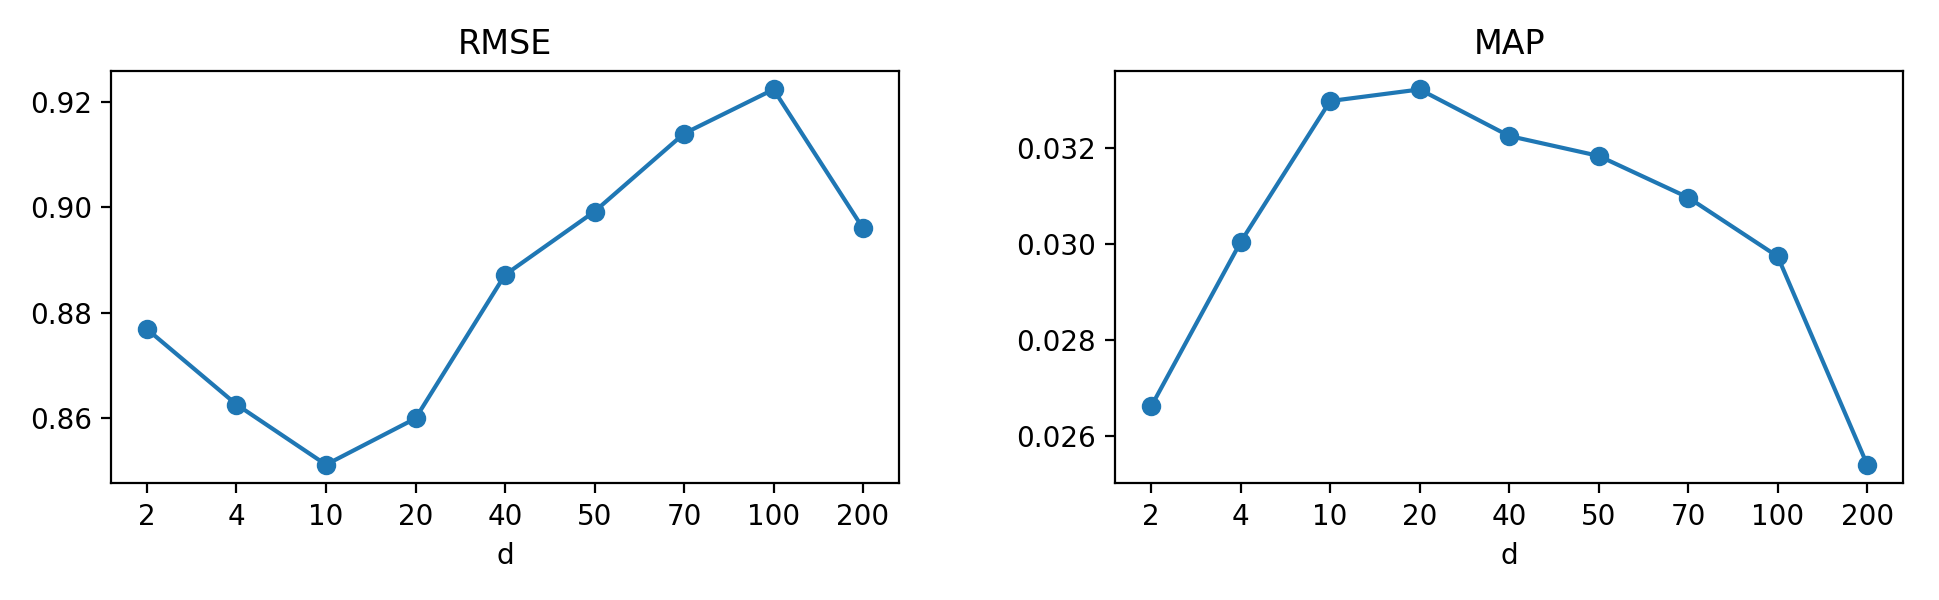

In [29]:
display(HTML('<span style="font-size: 24pt; background-color: #00ff00">Deliverable 3</span>'))
print('Optimzer: \033[1mALS\033[0m')
print('Regularization factor: ' + str(hyperparameters.lambda_bu))
print(algorithm_params)

f, axarr = plt.subplots(1, 2, figsize=(9.7, 3))

latent_dimensions_str = [str(val) for val in latent_dimensions]

axarr[0].plot(latent_dimensions_str, rmse_values, marker='o')
axarr[0].set_title('RMSE')
axarr[0].set_xlabel('d')
axarr[0].set_xticks(latent_dimensions_str)

axarr[1].plot(latent_dimensions_str, map_values, marker='o')
axarr[1].set_title('MAP')
axarr[1].set_xlabel('d')
axarr[1].set_xticks(latent_dimensions_str)

plt.tight_layout(w_pad=4.0)
pass

## Deliverable 4

<IPython.core.display.Javascript object>


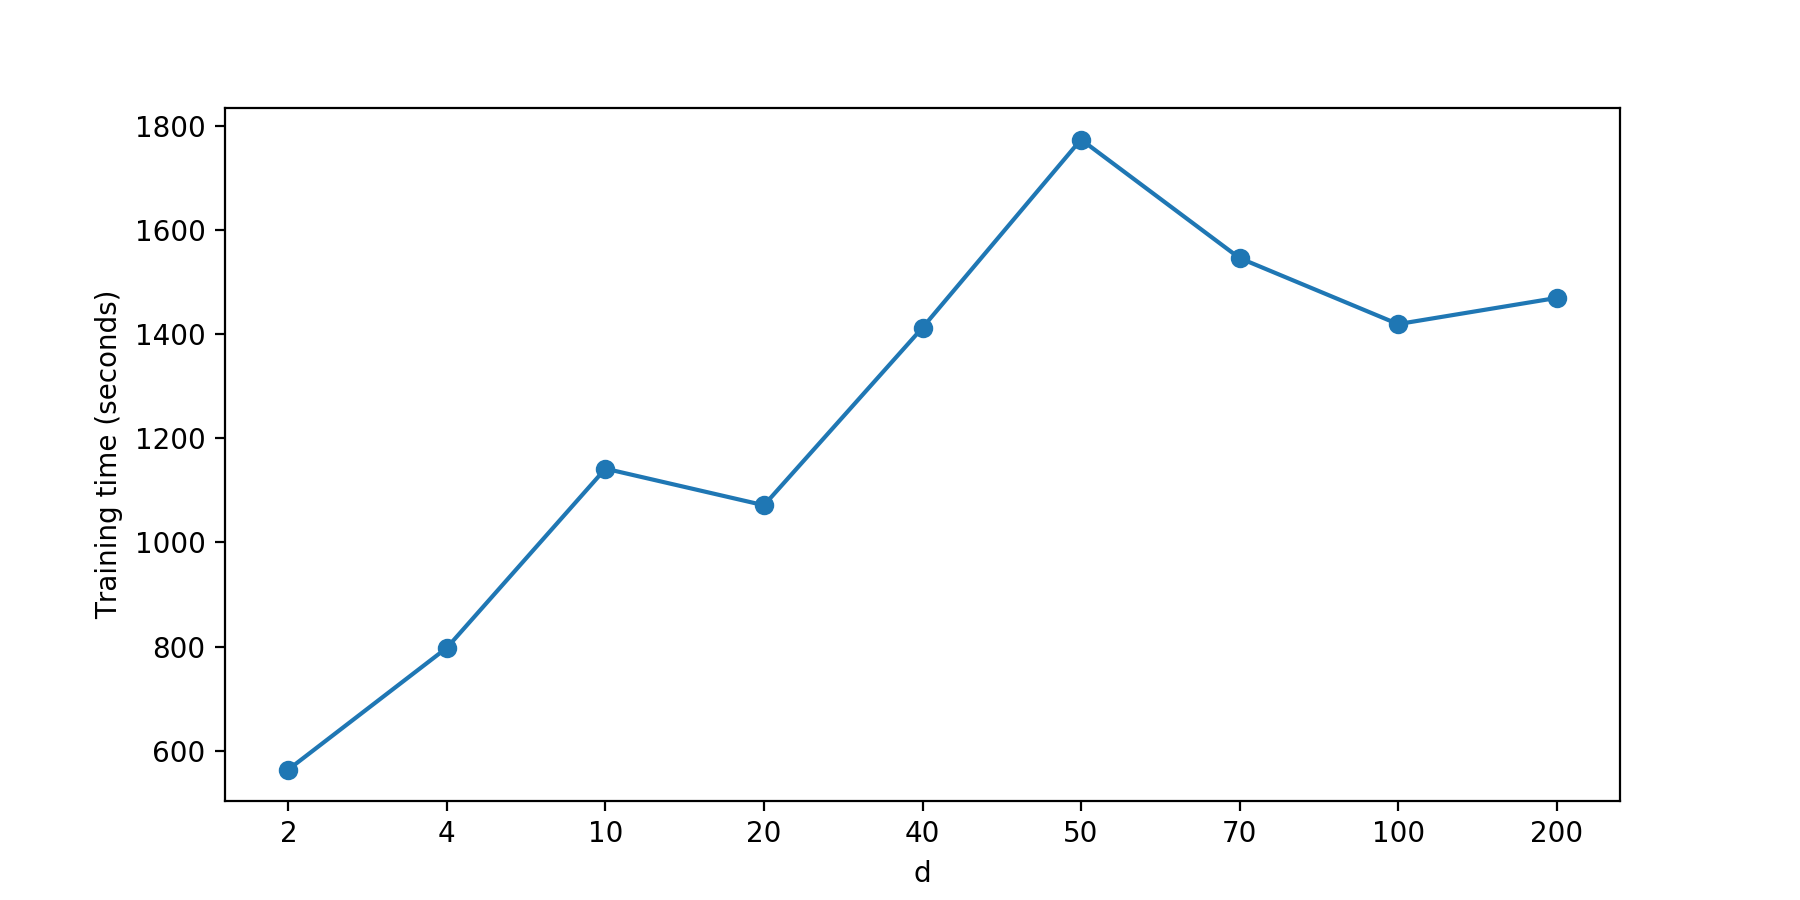

In [30]:
display(HTML('<span style="font-size: 24pt; background-color: #00ff00">Deliverable 4</span>'))
plt.figure(figsize=(9, 4.5))
train_times_sec = [t.total_seconds() for t in train_times]
plt.plot(latent_dimensions_str, train_times_sec, marker='o')
plt.xlabel('d')
plt.ylabel('Training time (seconds)')
pass

## Deliverable 5

In [31]:
hyperparameters = Hyperparameters(10, reg_users=10.0, reg_movies=10.0, reg_bias_users=10.0, reg_bias_movies=10.0)
model_params = MFModel(hyperparameters, train_set)
algorithm_params = ALSParameters(epocs=50, stop_threshold=50)
params = LearnModelFromDataUsingALS(train_set, model_params, algorithm_params, testset=test_set)

In [32]:
display(HTML('<span style="font-size: 24pt; background-color: #00ff00">Deliverable 5</span>'))
ratings_count = (~np.isnan(train_set)).sum(axis=1)
enough_ratings = np.argwhere((ratings_count >= 3) & (ratings_count <= 20)).reshape(-1)
chosen_students = np.random.choice(enough_ratings, 5)

for student in chosen_students:
    print('\n\n\033[1mStudent #%d:\033[0m' % student)
    print_user_recommendations(student, train_set, params)



Student #3333:

 Rating history
 ______________________________________________________________________
| Good, The Bad and The Ugly, The (1966)                         | 5.0 |
| Jaws (1975)                                                    | 5.0 |
| Rocky (1976)                                                   | 5.0 |
| Saving Private Ryan (1998)                                     | 5.0 |
| Star Wars: Episode IV - A New Hope (1977)                      | 5.0 |
| Run Lola Run (Lola rennt) (1998)                               | 5.0 |
| Goldfinger (1964)                                              | 5.0 |
| Hustler, The (1961)                                            | 5.0 |
| Die Hard (1988)                                                | 4.0 |
| E.T. the Extra-Terrestrial (1982)                              | 4.0 |
| King Kong (1933)                                               | 4.0 |
| Fistful of Dollars, A (1964)                                   | 4.0 |
| Thelma & Louise 


 Top-10 Recommendations
 ______________________________________________________________________
| Casablanca (1942)                                              | 4.7 |
| Godfather, The (1972)                                          | 4.7 |
| Dr. Strangelove or: How I Learned to Stop Worrying and Love th | 4.7 |
| Citizen Kane (1941)                                            | 4.6 |
| To Kill a Mockingbird (1962)                                   | 4.6 |
| Maltese Falcon, The (1941)                                     | 4.6 |
| Rear Window (1954)                                             | 4.6 |
| Chinatown (1974)                                               | 4.6 |
| African Queen, The (1951)                                      | 4.6 |
| Lawrence of Arabia (1962)                                      | 4.6 |
 ______________________________________________________________________


Student #916:

 Rating history
 ___________________________________________________________________